In [1]:
import numpy as np
import pandas as pd

In [2]:
portfolios_df = pd.read_csv('reports/strategies_portfolio.csv')

In [3]:
portfolios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    295 non-null    object 
 1   walk_forward_portfolio  295 non-null    float64
 2   buy_and_hold_portfolio  295 non-null    float64
 3   dca_portfolio           295 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.3+ KB


<Axes: xlabel='date'>

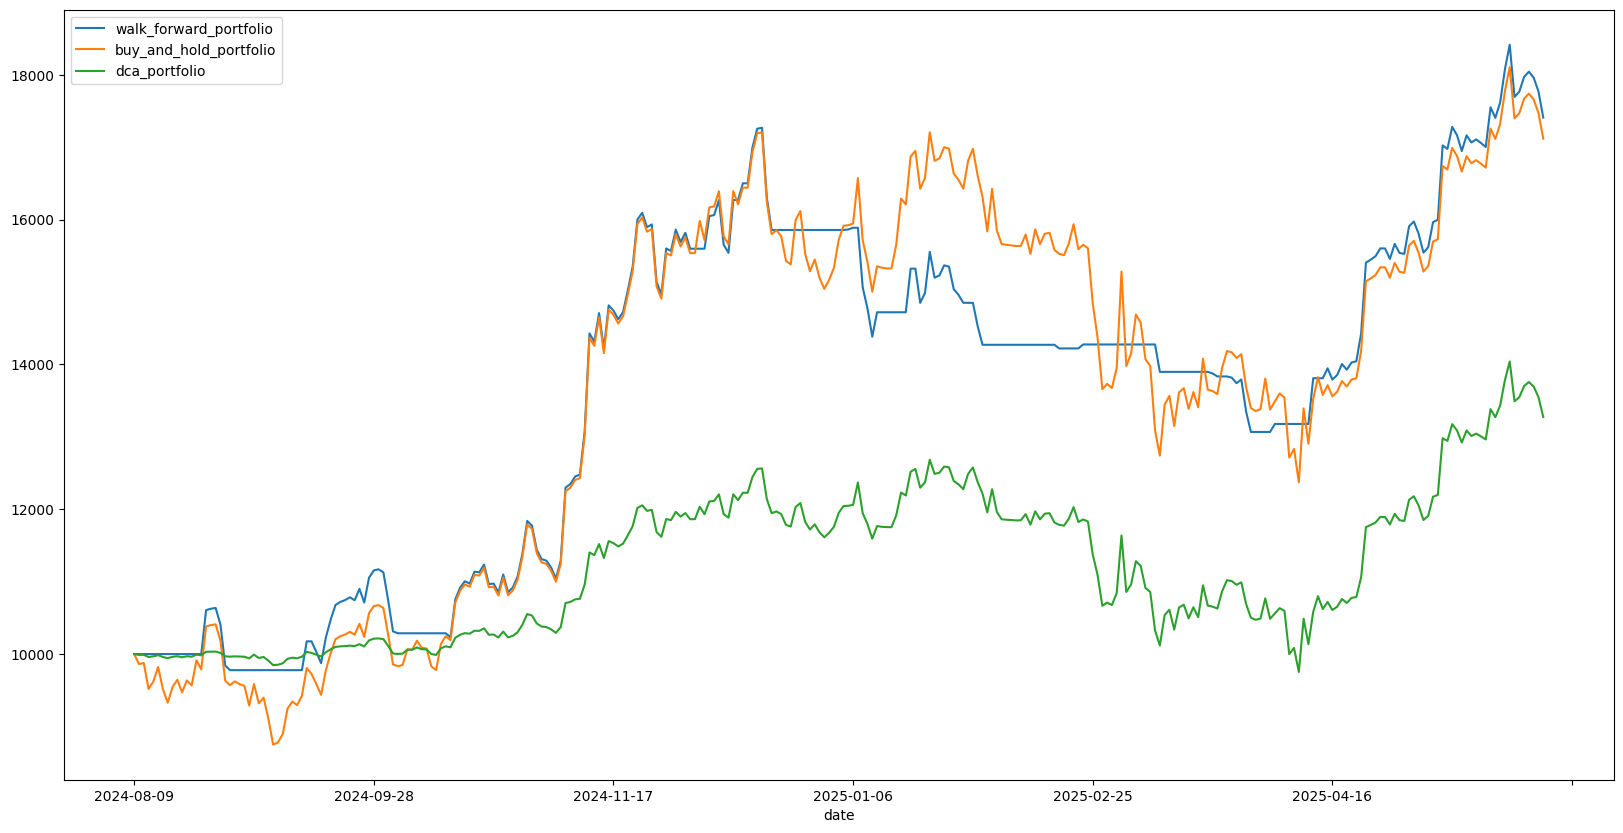

In [4]:
portfolios_df.set_index("date").plot(figsize=(20, 10))

In [5]:
import pandas as pd
import numpy as np

def compute_metrics(df, col, risk_free_rate=0.0):
    """
    Calcula métricas de performance y riesgo para una estrategia.
    df: DataFrame con 'date' y valores de portafolio
    col: columna con el valor del portafolio
    risk_free_rate: tasa libre de riesgo (diaria en este caso, default 0)
    """

    # Retornos diarios
    returns = df[col].pct_change().dropna()
    n_days = len(returns)
    total_period = (df['date'].iloc[-1] - df['date'].iloc[0]).days / 365.0

    # 1. Retorno Total
    total_return = df[col].iloc[-1] / df[col].iloc[0] - 1

    # 2. CAGR (retorno anualizado compuesto)
    cagr = (df[col].iloc[-1] / df[col].iloc[0])**(1/total_period) - 1

    # 3. Retorno Promedio Diario
    avg_daily_return = returns.mean()

    # 4. Volatilidad Anualizada
    vol_annualized = returns.std() * np.sqrt(365)

    # 5. Máximo Drawdown
    rolling_max = df[col].cummax()
    drawdown = df[col] / rolling_max - 1
    max_drawdown = drawdown.min()

    # 6. Tiempo de Recuperación (en días)
    end_of_dd = (drawdown.idxmin())
    recov_time = (df.index[df[col].iloc[end_of_dd:].cummax().idxmax()] - end_of_dd) if max_drawdown < 0 else 0

    # 7. Sharpe Ratio (anualizado)
    sharpe = (avg_daily_return - risk_free_rate) / returns.std() * np.sqrt(365)

    # 8. Sortino Ratio (anualizado)
    downside_returns = returns[returns < 0]
    sortino = (avg_daily_return - risk_free_rate) / downside_returns.std() * np.sqrt(365) if len(downside_returns) > 0 else np.nan

    # 9. Calmar Ratio
    calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan

    # 10. Alpha (vs. benchmark: aquí usaremos Buy & Hold como referencia)
    # → Se calculará afuera comparando con otra estrategia

    return {
        "Total Return": total_return,
        "CAGR": cagr,
        "Avg Daily Return": avg_daily_return,
        "Annualized Vol": vol_annualized,
        "Max Drawdown": max_drawdown,
        "Recovery Time (days)": recov_time,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Calmar Ratio": calmar,
    }

portfolios_df['date'] = pd.to_datetime(portfolios_df['date'])
df = portfolios_df.sort_values('date').reset_index(drop=True)

strategies = ["walk_forward_portfolio", "buy_and_hold_portfolio", "dca_portfolio"]

metrics = {}
for strat in strategies:
    metrics[strat] = compute_metrics(df, strat)

metrics_df = pd.DataFrame(metrics).T
metrics_df.insert(0, 'Strategy', metrics_df.index.str.replace('_', ' ').str.title())
metrics_df = metrics_df.reset_index(drop=True)

metrics_df


,Strategy,Total Return,CAGR,Avg Daily Return,Annualized Vol,Max Drawdown,Recovery Time (days),Sharpe Ratio,Sortino Ratio,Calmar Ratio
0,Walk Forward Portfolio,0.740900,0.990307,0.002053,0.351175,-0.243253,54.0,2.134098,2.844846,4.071103
1,Buy And Hold Portfolio,0.711730,0.948987,0.002148,0.484457,-0.280953,44.0,1.618181,2.609351,3.377746
2,Dca Portfolio,0.327372,0.421330,0.001100,0.317207,-0.231087,44.0,1.266165,1.770107,1.823253


In [6]:
metrics_df.to_csv("reports/strategy_metrics.csv", index=False)

In [7]:
import statsmodels.api as sm

def compute_alpha_beta(df, strategy_col, benchmark_col="buy_and_hold_portfolio"):
    """
    Calcula Alpha y Beta de una estrategia contra un benchmark usando regresión lineal.
    """
    # Retornos diarios
    strat_returns = df[strategy_col].pct_change().dropna()
    bench_returns = df[benchmark_col].pct_change().dropna()

    # Alinear fechas
    aligned = pd.concat([strat_returns, bench_returns], axis=1, join="inner").dropna()
    y = aligned[strategy_col]
    X = sm.add_constant(aligned[benchmark_col])  # agrega constante para alpha

    model = sm.OLS(y, X).fit()
    alpha = model.params["const"]
    beta = model.params[benchmark_col]

    return alpha, beta

# --- Uso ---
alpha_beta_results = {}
for strat in ["walk_forward_portfolio", "dca_portfolio"]:  # excluimos buy_and_hold porque es benchmark
    alpha, beta = compute_alpha_beta(df, strat)
    alpha_beta_results[strat] = {"Alpha": alpha, "Beta": beta}

alpha_beta_df = pd.DataFrame(alpha_beta_results).T

In [8]:
alpha_beta_df.insert(0, 'Strategy', alpha_beta_df.index.str.replace('_', ' ').str.title())
alpha_beta_df = alpha_beta_df.reset_index(drop=True)

In [9]:
alpha_beta_df

,Strategy,Alpha,Beta
0,Walk Forward Portfolio,0.000925,0.525152
1,Dca Portfolio,-0.000172,0.592584


In [10]:
alpha_beta_df.to_csv("reports/strategy_alpha_beta.csv", index=False)